In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

path = kagglehub.dataset_download("kabure/german-credit-data-with-risk")
df = pd.read_csv(f"{path}/german_credit_data.csv")

Using Colab cache for faster access to the 'german-credit-data-with-risk' dataset.


In [5]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
print("Original DataFrame Head:")
print(df.head())

Original DataFrame Head:
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad  


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [8]:
print("check missing values")
print(df.isna().sum())

check missing values
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [9]:
df.drop(columns='Unnamed: 0', inplace=True)

In [10]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,1000,2,good,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df['Age'].describe()

,Age
count,1000.000000
mean,35.546000
std,11.375469
min,19.000000
25%,27.000000
50%,33.000000
75%,42.000000
max,75.000000


In [12]:
df['Risk'].value_counts()

,count
Risk,
good,700
bad,300


In [13]:
df['Job'].unique()

array([2, 1, 3, 0])

In [14]:
for col in ['Saving accounts', 'Checking account']:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-3001346375.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [15]:
print(df.isna().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


In [16]:
# add new features
# Create a credit-to-duration ratio
# Hypothesis: The monthly payment pressure might be a good indicator of risk
df['credit_duration_ratio'] = df['Credit amount'] / df['Duration']

# Create categorical age groups
# Hypothesis: Risk may vary by age group rather than linearly with age
age_bins = [18, 30, 45, 60, 80]
age_labels = ['Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

In [17]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,credit_duration_ratio,age_group
0,67,male,2,own,little,little,1169,6,radio/TV,good,194.833333,Elderly
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,123.979167,Young Adult
2,49,male,1,own,little,little,2096,12,education,good,174.666667,Senior
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,187.666667,Senior
4,53,male,2,free,little,little,4870,24,car,bad,202.916667,Senior


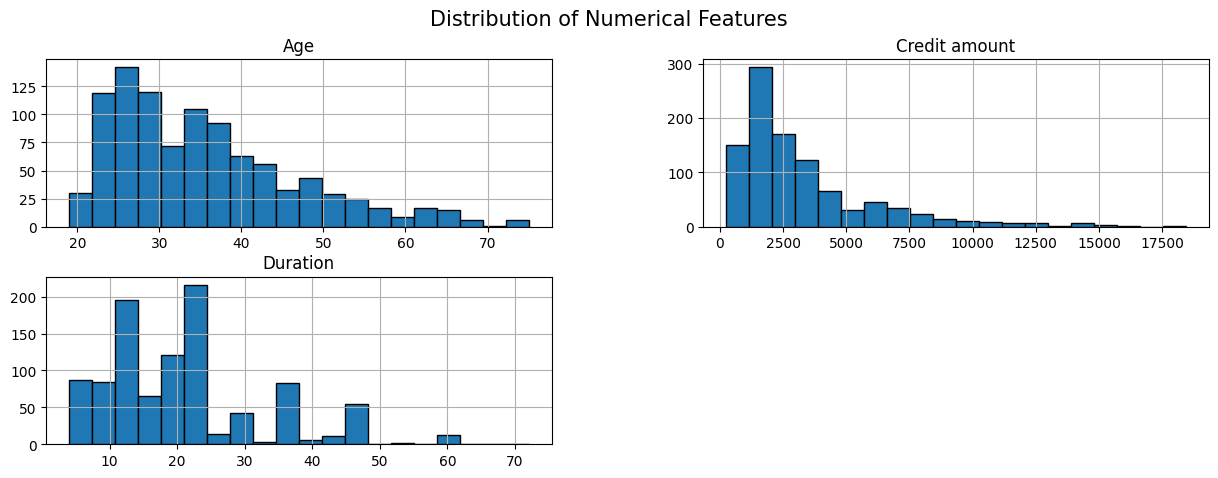

In [18]:
# Distribution of numerical features
df[['Age', 'Credit amount', 'Duration']].hist(bins=20, edgecolor='black', figsize=(15, 5))
plt.suptitle('Distribution of Numerical Features', fontsize=15)
plt.show()

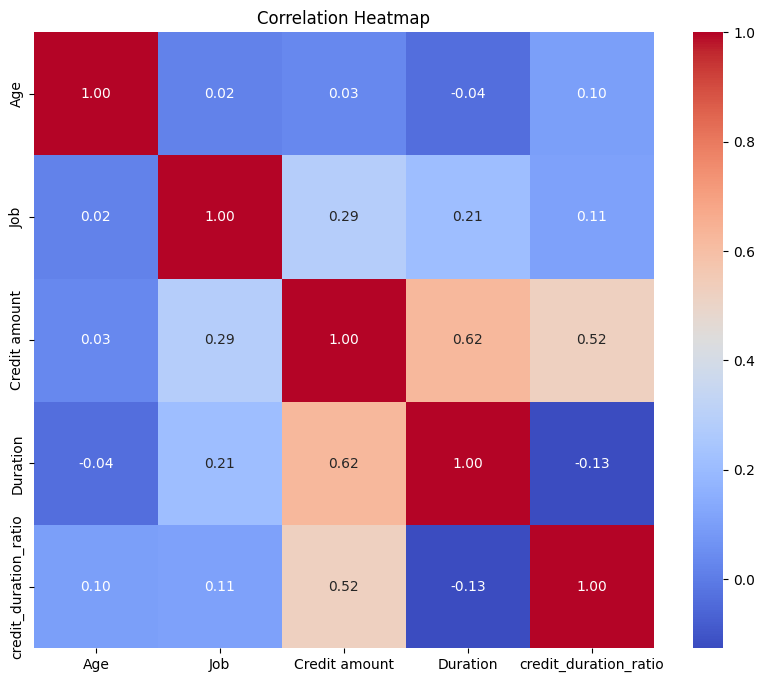

In [19]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

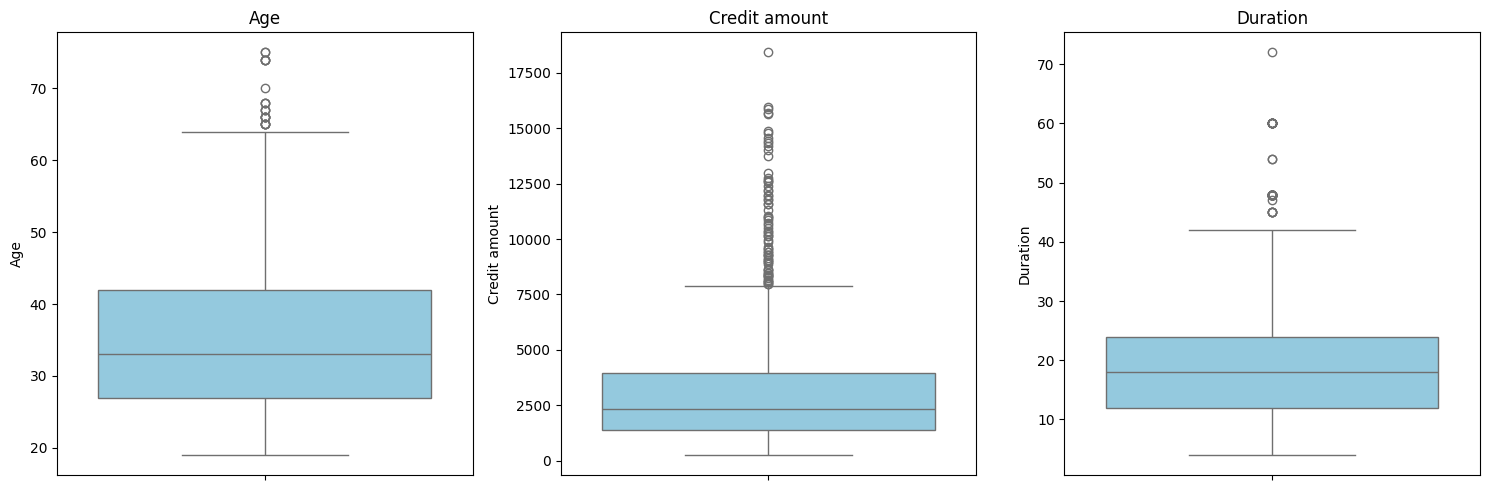

In [20]:
plt.figure(figsize = (15, 5))
for i, col in enumerate(['Age', 'Credit amount', 'Duration']):
  plt.subplot(1, 3, i + 1)
  sns.boxplot(y = df[col], color = 'skyblue')
  plt.title(col)

plt.tight_layout()
plt.show()

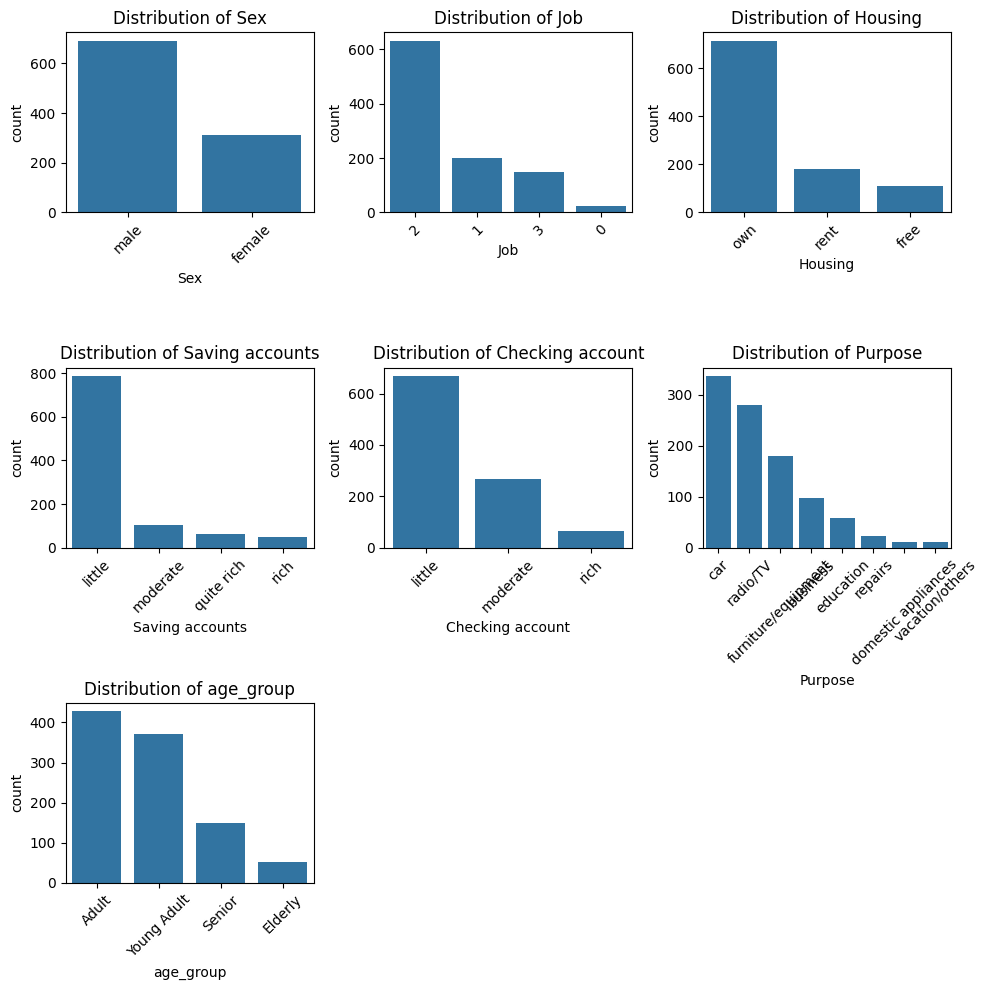

In [21]:
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'age_group']

plt.figure(figsize = (10, 10))
for i, col in enumerate(categorical_cols):
  plt.subplot(3, 3, i + 1)
  sns.countplot(data = df, x = col, order = df[col].value_counts().index)
  # sns.countplot(x = df[col], palette = 'Set2', order = df[col].value_counts().index)
  plt.title(f"Distribution of {col}")
  plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

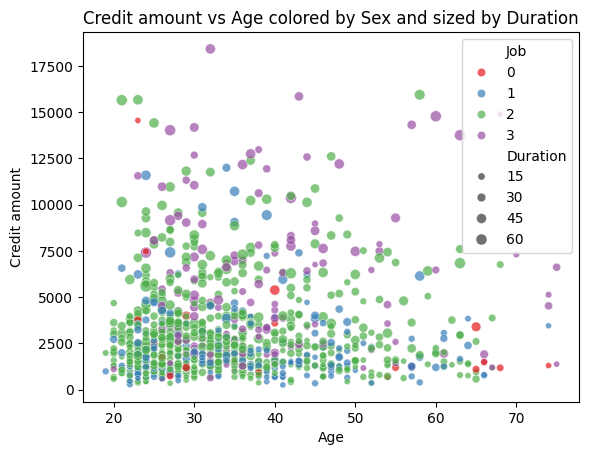

In [22]:
sns.scatterplot(data = df, x = "Age", y = "Credit amount", hue = 'Job', size = 'Duration', alpha = 0.7, palette = 'Set1')
plt.title('Credit amount vs Age colored by Sex and sized by Duration')
plt.show()

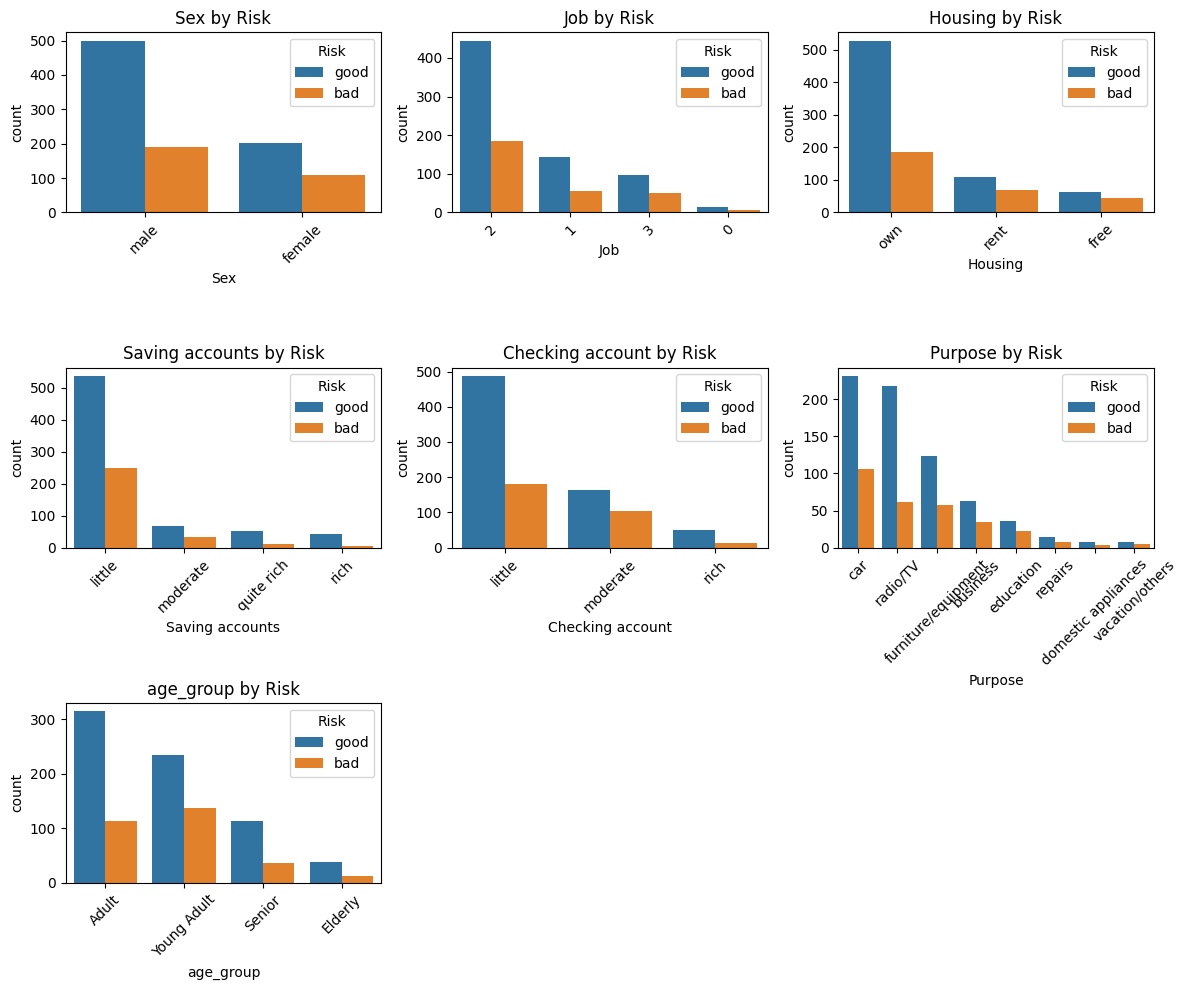

In [23]:
plt.figure(figsize = (12, 10))
for i, col in enumerate(categorical_cols):
  plt.subplot(3, 3, i + 1)
  sns.countplot(data = df, x = col, hue = 'Risk', order = df[col].value_counts().index)
  # sns.boxplot(data = df, y = col)
  plt.title(f"{col} by Risk")
  plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


In [24]:
# Define features and target
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'credit_duration_ratio', 'age_group']
target = 'Risk'

df_model = df[features + [target]].copy()

# Encode categorical features
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.drop('Risk')
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col] = le

# Encode the target variable
le_target = LabelEncoder()
df_model[target] = le_target.fit_transform(df_model[target])
# joblib.dump(le_target, 'target_encoder.pkl') # Optional: save target encoder

print("\nDataFrame head after encoding:")
df_model.head()


DataFrame head after encoding:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,credit_duration_ratio,age_group,Risk
0,67,1,2,1,0,0,1169,6,5,194.833333,1,1
1,22,0,2,1,0,1,5951,48,5,123.979167,3,0
2,49,1,1,1,0,0,2096,12,3,174.666667,2,1
3,45,1,2,0,0,0,7882,42,4,187.666667,2,1
4,53,1,2,0,0,0,4870,24,1,202.916667,2,0


In [25]:
# train test split
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

def train_model(model, param_grid, X_train, y_train, X_test, y_test, use_grid=True):

    if use_grid:
        grid = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring='recall',
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = None

    # Predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"--- Results for {best_model.__class__.__name__} ---")
    if best_params:
        print(f"Best Parameters: {best_params}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("--------------------------------------------------\n")

    return best_model, acc, recall, roc_auc, best_params


In [27]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model, acc_log, recall_log, roc_log, _ = train_model(
    log_model,
    param_grid=None,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    use_grid=False
)


--- Results for LogisticRegression ---
Accuracy : 0.6300
Recall   : 0.6429
ROC-AUC  : 0.6445

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.60      0.49        60
           1       0.79      0.64      0.71       140

    accuracy                           0.63       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.68      0.63      0.64       200


Confusion Matrix:
[[36 24]
 [50 90]]
--------------------------------------------------



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Define models and their parameter grids
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
rf_param_grid = {
    "n_estimators": [100, 200], "max_depth": [5, 7, 10, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]
}

# Calculate scale_pos_weight for XGBoost
count_bad = (y_train == 0).sum() # 'bad' is encoded as 0
count_good = (y_train == 1).sum() # 'good' is encoded as 1
scale_pos_weight = count_bad / count_good

xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight)
xgb_param_grid = {
    "n_estimators": [100, 200, 300], "max_depth": [3, 5, 7], "learning_rate": [0.01, 0.1, 0.2], "subsample": [0.7, 1], "colsample_bytree": [0.7, 1]
}

# Train and evaluate the models
print("Training Decision Tree...")
best_dt, acc_dt, recall_dt, roc_dt, params_dt = train_model(
    dt, dt_param_grid, X_train, y_train, X_test, y_test
)

print("Training Random Forest...")
best_rf, acc_rf, recall_rf, roc_rf, params_rf = train_model(
    rf, rf_param_grid, X_train, y_train, X_test, y_test
)

print("Training XGBoost...")
best_xgb, acc_xgb, recall_xgb, roc_xgb, params_xgb = train_model(
    xgb, xgb_param_grid, X_train, y_train, X_test, y_test
)


Training Decision Tree...
--- Results for DecisionTreeClassifier ---
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy : 0.6300
Recall   : 0.7000
ROC-AUC  : 0.5890

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43        60
           1       0.75      0.70      0.73       140

    accuracy                           0.63       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.65      0.63      0.64       200


Confusion Matrix:
[[28 32]
 [42 98]]
--------------------------------------------------

Training Random Forest...
--- Results for RandomForestClassifier ---
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy : 0.7100
Recall   : 0.9000
ROC-AUC  : 0.6383

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.27      0.36     

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:41:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

roc_log = roc_auc_score(y_test, y_prob_log)
print("Logistic Regression ROC-AUC:", roc_log)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.60      0.49        60
           1       0.79      0.64      0.71       140

    accuracy                           0.63       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.68      0.63      0.64       200

Logistic Regression ROC-AUC: 0.6445238095238095


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
!pip install shap


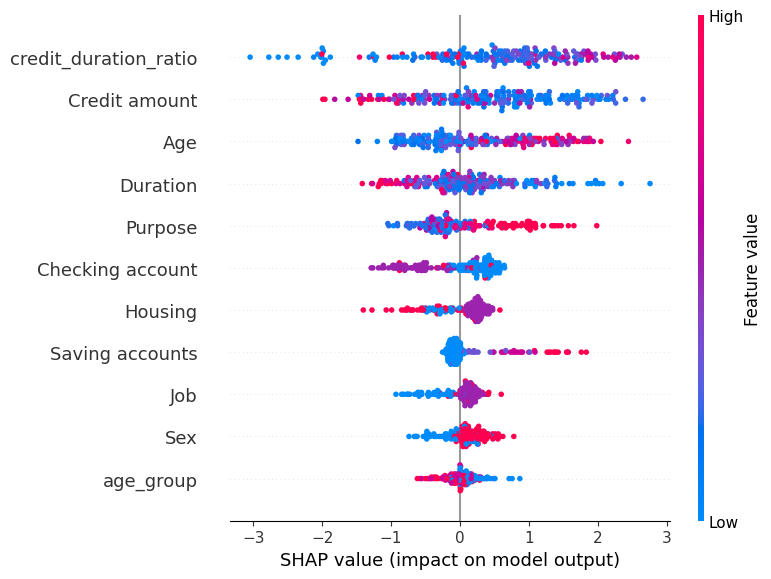

In [34]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


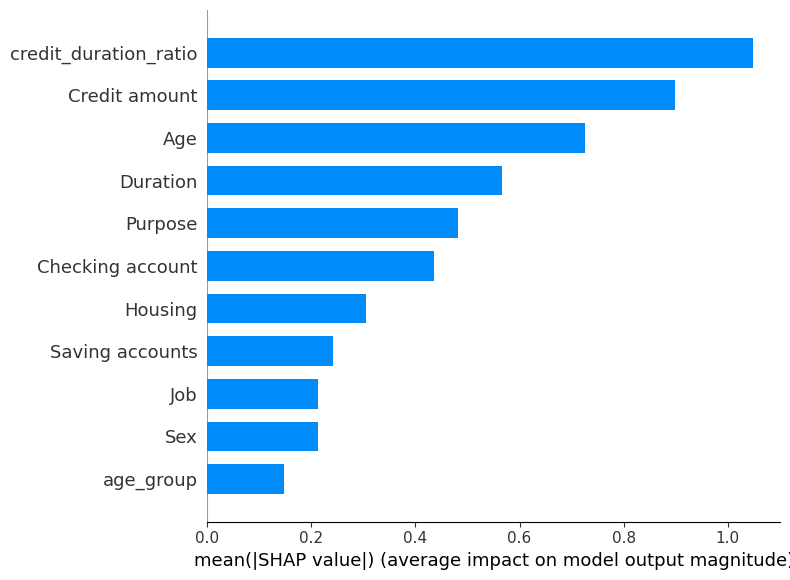

In [35]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [36]:
shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0]
)


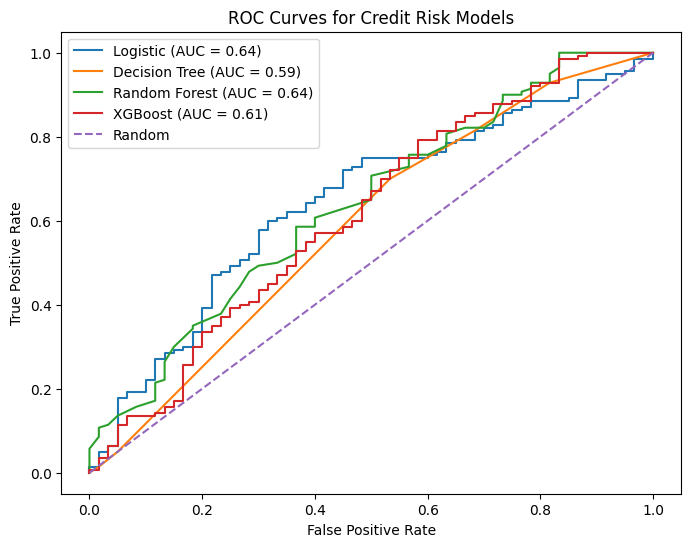

In [37]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {roc_log:.2f})")

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_dt:.2f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_rf:.2f})")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_xgb:.2f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Credit Risk Models")
plt.legend()
plt.show()
